In [1]:
from Robinhood import Robinhood
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import time
import datetime as dt

==================================================tickers============================================================

In [2]:
#technical indicators
#column names: time, open_price, close_price, high_price, low_price, volume

#Average True Range
def atr(df,n):
    df['h-l']=abs(df['high_price']-df['low_price'])
    df['h-pc']=abs(df['high_price']-df['close_price'].shift(1))
    df['l-pc']=abs(df['low_price']-df['close_price'].shift(1))
    df['tr']=df[['h-l','h-pc','l-pc']].max(axis=1,skipna=False)
    df['atr'] = df['tr'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    #df = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df['atr']

#cumulative annual growth rate
def cagr(df):
    #df['ret'] = df['close_price'].pct_change()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    n = len(df)/len(df)
    cagr = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return cagr

#volatility
def volatility(df):
    #df['ret'] = df['close_price'].pct_change()
    vol = df["ret"].std() * np.sqrt(len(df))
    return vol

#sharpe ratio, rf is the risk free ratio

def sharpe(df, rf):
    sr = (cagr(df) - rf)/volatility(df)
    return sr

def max_dd(df):
    df["cum_return"] = (1 + df["ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

In [3]:
#get historical trade data
def get_ohlcv(robinhood_client, tickers, itvl, prd): #tickers is a list of tickers, itvl: interval, prd: period
    ohlcv = {}
    for ticker in tickers:
        print(ticker)
        print('retreiving data for ' + ticker)
        data = robinhood_client.get_historical_quotes(ticker, itvl, prd)['results'][0]['historicals']
        df = pd.DataFrame(data = data)
#        df = df.dropna(inplace = True)
#        print(df)
        df.columns.values[0] = "time"
        df["time"] = pd.to_datetime(df['time'])  #'%Y-%m-%dT%H:%M:%SZ
        df = df.set_index("time")
        df.index = df.index.tz_convert('US/Eastern')
        #df["time"] = dt.datetime.strptime(df['time'].astype(str), "%Y-%m-%d %H:%M:%S")
        df = df.iloc[:, :-2]
        df[['open_price', 'close_price', 'high_price', 'low_price']] = df[['open_price', 'close_price', 'high_price', 'low_price']].apply(pd.to_numeric)
        #=====================
        df['atr'] = atr(df, 20)
        df['roll_max_cp'] = df['high_price'].rolling(20).max()
        df['roll_min_cp'] = df['low_price'].rolling(20).max()
        df['roll_max_vol'] = df['volume'].rolling(20).max()
        ohlcv[ticker] = df
    return ohlcv

In [4]:
robinhood_client = Robinhood()
robinhood_client.login(username = 'yiwenluo1@outlook.com', password = 'lyw729rolling')

No 2FA Given
SMS Code:
147818


True

In [11]:
#import stock ticers from robinhood lists
def scrape_table(table_url):
    #get table
    page = requests.get(table_url)
    page_content = page.content
    soup = BeautifulSoup(page_content, 'html.parser')
    table = soup.find_all('table', {'id': 'constituents'})

    #read scraped data into list
    all_rows = [] 
    for t in table:
        rows = t.find_all('tr')
        for row in rows:
            value = row.get_text()
            all_rows.append(value)

    #convert list to dataframe
    df = pd.DataFrame(all_rows)
    df = df[0].str.split('\n', expand = True)
    df = df.iloc[1:, [1, 3]]
    df.columns = ['symbol', 'security']
    return df

#append last trade price to tickers, price is converted into float
def append_price(df):
    df['last_trade_price'] = df['symbol'].apply(lambda x: robinhood_client.quote_data(x)['last_trade_price'])
    df['last_trade_price'] = df['last_trade_price'].apply(pd.to_numeric)
    return df


#s&p 500 wikipedia url
snp_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

snp = append_price(scrape_table(snp_url))

snp_s = snp[snp.last_trade_price < 50]
my_tickers = snp_s['symbol'].values.tolist()

ohlcv = get_ohlcv(robinhood_client, my_tickers, '5minute', 'week')

AES
retreiving data for AES
AFL
retreiving data for AFL
ALK
retreiving data for ALK
MO
retreiving data for MO
AMCR
retreiving data for AMCR
AAL
retreiving data for AAL
AIG
retreiving data for AIG
AOS
retreiving data for AOS
APA
retreiving data for APA
AIV
retreiving data for AIV
ADM
retreiving data for ADM
T
retreiving data for T
BKR
retreiving data for BKR
BAC
retreiving data for BAC
BK
retreiving data for BK
BWA
retreiving data for BWA
BSX
retreiving data for BSX
COG
retreiving data for COG
CAH
retreiving data for CAH
CCL
retreiving data for CCL
CARR
retreiving data for CARR
CBRE
retreiving data for CBRE
CNP
retreiving data for CNP
CTL
retreiving data for CTL
CF
retreiving data for CF
SCHW
retreiving data for SCHW
CSCO
retreiving data for CSCO
C
retreiving data for C
CFG
retreiving data for CFG
KO
retreiving data for KO
CMCSA
retreiving data for CMCSA
CMA
retreiving data for CMA
CAG
retreiving data for CAG
CXO
retreiving data for CXO
COP
retreiving data for COP
GLW
retreiving data fo

In [6]:
#0810 TOP MOVERS
my_tickers = ['GRPN', 'TDC', 'UFS', 'SG', 'TRUE', 'NUZE', 'RC', 'SSTI', 'OCFT', 'YELP', 'VIVO', 'PETQ', 'PDFS', 'NH']
ohlcv = get_ohlcv(robinhood_client, my_tickers, '5minute', 'week')

GRPN
retreiving data for GRPN
TDC
retreiving data for TDC
UFS
retreiving data for UFS
SG
retreiving data for SG
TRUE
retreiving data for TRUE
NUZE
retreiving data for NUZE
RC
retreiving data for RC
SSTI
retreiving data for SSTI
OCFT
retreiving data for OCFT
YELP
retreiving data for YELP
VIVO
retreiving data for VIVO
PETQ
retreiving data for PETQ
PDFS
retreiving data for PDFS
NH
retreiving data for NH


In [24]:
my_tickers = ['FCX', 'CTL', 'BKR', 'RF', 'SYF', 'UNM', 'OKE', 'NLOK', 'IVZ']
ohlcv = get_ohlcv(robinhood_client, my_tickers, '5minute', 'week')

FCX
retreiving data for FCX
CTL
retreiving data for CTL
BKR
retreiving data for BKR
RF
retreiving data for RF
SYF
retreiving data for SYF
UNM
retreiving data for UNM
OKE
retreiving data for OKE
NLOK
retreiving data for NLOK
IVZ
retreiving data for IVZ


In [18]:
#cannabis tickers
my_tickers = ['ACB', 'CGC', 'CRON', 'TLRY', 'SSPK', 'HEXO', 'OGI', 'SPRWF', 
              'SNDL', 'CNTTQ', 'HUGE', 'GTEC', 'SCNA', 'TRTC', 'PURA', 'HEMP',
             'HMPQ']
ohlcv = get_ohlcv(robinhood_client, my_tickers, '5minute', 'week')

ACB
retreiving data for ACB
CGC
retreiving data for CGC
CRON
retreiving data for CRON
TLRY
retreiving data for TLRY
SSPK
retreiving data for SSPK
HEXO
retreiving data for HEXO
OGI
retreiving data for OGI
SPRWF
retreiving data for SPRWF
SNDL
retreiving data for SNDL
CNTTQ
retreiving data for CNTTQ
HUGE
retreiving data for HUGE
GTEC
retreiving data for GTEC
SCNA
retreiving data for SCNA
TRTC
retreiving data for TRTC
PURA
retreiving data for PURA
HEMP
retreiving data for HEMP
HMPQ
retreiving data for HMPQ


In [7]:
#top movers tickers
my_tickers = ['OSTK', 'PRK', 'SBH', 'MTLS', 'UCTT', 'TSE', 'HOME', 'PDFS', 'LMNL', 
              'PI', 'GTX', 'KRA', 'EROS', 'BLCT', 'TAOP', 'QEP', 'SPPI', 'BLNK',
              'MOGU', 'ADMA']
ohlcv = get_ohlcv(robinhood_client, my_tickers, '5minute', 'week')

OSTK
retreiving data for OSTK
PRK
retreiving data for PRK
SBH
retreiving data for SBH
MTLS
retreiving data for MTLS
UCTT
retreiving data for UCTT
TSE
retreiving data for TSE
HOME
retreiving data for HOME
PDFS
retreiving data for PDFS
LMNL
retreiving data for LMNL
PI
retreiving data for PI
GTX
retreiving data for GTX
KRA
retreiving data for KRA
EROS
retreiving data for EROS
BLCT
retreiving data for BLCT
TAOP
retreiving data for TAOP
QEP
retreiving data for QEP
SPPI
retreiving data for SPPI
BLNK
retreiving data for BLNK
MOGU
retreiving data for MOGU
ADMA
retreiving data for ADMA


In [39]:
#upcoming earnings 
my_tickers = ['NOK', 'SIRI', 'NOG', 'PCG', 'RWT', 'FCAU', 'CMCSA', 'ICAGY', 'TBIO', 'KTOS']
ohlcv = get_ohlcv(robinhood_client, my_tickers, '5minute', 'week')

NOK
retreiving data for NOK
SIRI
retreiving data for SIRI
NOG
retreiving data for NOG
PCG
retreiving data for PCG
RWT
retreiving data for RWT
FCAU
retreiving data for FCAU
CMCSA
retreiving data for CMCSA
ICAGY
retreiving data for ICAGY
TBIO
retreiving data for TBIO
KTOS
retreiving data for KTOS


==================================================backtesting============================================================

strategy 1: resistance breakout

In [22]:
# using resistance breakout strategy
# identifying signals and calculating daily return (stop loss factored in)
def set_signal(tickers):
    tickers_signal = {}
    for ticker in tickers:
        tickers_signal[ticker] = ''
    return tickers_signal

def set_ret(tickers):
    tickers_ret = {}
    for ticker in tickers:
        tickers_ret[ticker] = []
    return tickers_ret

def set_history(tickers):
    tickers_hist = {}
    for ticker in tickers:
        tickers_hist[ticker] = []
    return tickers_hist

def set_latest_buy(tickers):
    tickers_latest_buy = {}
    for ticker in tickers:
        tickers_latest_buy[ticker] = -1
    return tickers_latest_buy

def set_latest_sell(tickers):
    tickers_latest_sell = {}
    for ticker in tickers:
        tickers_latest_sell[ticker] = -1
    return tickers_latest_sell

tickers_signal = set_signal(my_tickers)
tickers_ret = set_ret(my_tickers)
tickers_hist = set_history(my_tickers)
tickers_latest_buy = set_latest_buy(my_tickers)
tickers_latest_sell = set_latest_sell(my_tickers)

for ticker in my_tickers:
    hist = []
    print("calculating returns for ",ticker)
    for i in range(len(ohlcv[ticker])):
        if tickers_signal[ticker] == "":
            tickers_ret[ticker].append(0)
            if ohlcv[ticker]["high_price"][i]>=ohlcv[ticker]["roll_max_cp"][i] and \
               ohlcv[ticker]["volume"][i]>1.5*ohlcv[ticker]["roll_max_vol"][i-1] and \
                tickers_latest_sell[ticker] < ohlcv[ticker].index[i].day and\
                ohlcv[ticker]["close_price"][i]*(sum(tickers_hist[ticker]) + 1) <= 100:
                tickers_signal[ticker] = "buy"
                tickers_latest_buy[ticker] = ohlcv[ticker].index[i].day #prevent pattern day trader flag
                tickers_hist[ticker].append(1)
                
            elif ohlcv[ticker]["low_price"][i]<=ohlcv[ticker]["roll_min_cp"][i] and \
               ohlcv[ticker]["volume"][i]>1.5*ohlcv[ticker]["roll_max_vol"][i-1] and \
                sum(tickers_hist[ticker]) > 0 and \
                tickers_latest_buy[ticker] < ohlcv[ticker].index[i].day:
                tickers_signal[ticker] = "sell"
                tickers_latest_sell[ticker] = ohlcv[ticker].index[i].day #prevent pattern day trader flag
                tickers_hist[ticker].append(-1)
            else: 
                tickers_hist[ticker].append(0)
        
        elif tickers_signal[ticker] == "buy":
            if ((ohlcv[ticker]["close_price"][i]<ohlcv[ticker]["close_price"][i-1] - ohlcv[ticker]["atr"][i-1]) | \
                (ohlcv[ticker]["close_price"][i]*(sum(tickers_hist[ticker]) + 1) > 100)):
                tickers_signal[ticker] = ""
                tickers_ret[ticker].append(((ohlcv[ticker]["close_price"][i-1] - ohlcv[ticker]["atr"][i-1])/ohlcv[ticker]["close_price"][i-1])-1)
                tickers_hist[ticker].append(0)
            elif ohlcv[ticker]["low_price"][i]<=ohlcv[ticker]["roll_min_cp"][i] and \
               ohlcv[ticker]["volume"][i]>1.5*ohlcv[ticker]["roll_max_vol"][i-1] and \
                sum(tickers_hist[ticker]) > 0 and \
                tickers_latest_buy[ticker] < ohlcv[ticker].index[i].day:
                tickers_signal[ticker] = "sell"
                tickers_ret[ticker].append(((ohlcv[ticker]["close_price"][i-1] - ohlcv[ticker]["atr"][i-1])/ohlcv[ticker]["close_price"][i-1])-1)
                tickers_latest_sell[ticker] = ohlcv[ticker].index[i].day #prevent pattern day trader flag
                tickers_hist[ticker].append(-1)
            else:
                tickers_ret[ticker].append((ohlcv[ticker]["close_price"][i]/ohlcv[ticker]["close_price"][i-1])-1)
                tickers_latest_buy[ticker] = ohlcv[ticker].index[i].day #prevent pattern day trader flag
                tickers_hist[ticker].append(1)
        
        elif tickers_signal[ticker] == "sell" and sum(tickers_hist[ticker]) > 0:
            if ohlcv[ticker]["close_price"][i]>ohlcv[ticker]["close_price"][i-1] + ohlcv[ticker]["atr"][i-1]:
                tickers_signal[ticker] = ""
                tickers_ret[ticker].append((ohlcv[ticker]["close_price"][i-1]/(ohlcv[ticker]["close_price"][i-1] + ohlcv[ticker]["atr"][i-1]))-1)
                tickers_hist[ticker].append(0)
            elif ohlcv[ticker]["high_price"][i]>=ohlcv[ticker]["roll_max_cp"][i] and \
               ohlcv[ticker]["volume"][i]>1.5*ohlcv[ticker]["roll_max_vol"][i-1] and \
                tickers_latest_sell[ticker] < ohlcv[ticker].index[i].day and \
                ohlcv[ticker]["close_price"][i]*(sum(tickers_hist[ticker]) + 1) <= 100:
                tickers_signal[ticker] = "buy"
                tickers_ret[ticker].append((ohlcv[ticker]["close_price"][i-1]/(ohlcv[ticker]["close_price"][i-1] + ohlcv[ticker]["atr"][i-1]))-1)
                tickers_latest_buy[ticker] = ohlcv[ticker].index[i].day #prevent pattern day trader flag
                tickers_hist[ticker].append(1)
            else:
                tickers_ret[ticker].append((ohlcv[ticker]["close_price"][i-1]/ohlcv[ticker]["close_price"][i])-1)
                tickers_latest_sell[ticker] = ohlcv[ticker].index[i].day #prevent pattern day trader flag
                tickers_hist[ticker].append(-1)
        
        elif tickers_signal[ticker] == "sell" and sum(tickers_hist[ticker]) <= 0:
            if ohlcv[ticker]["close_price"][i]>ohlcv[ticker]["close_price"][i-1] + ohlcv[ticker]["atr"][i-1]:
                tickers_signal[ticker] = ""
                tickers_ret[ticker].append(0)
                tickers_hist[ticker].append(0)
            elif ohlcv[ticker]["high_price"][i]>=ohlcv[ticker]["roll_max_cp"][i] and \
               ohlcv[ticker]["volume"][i]>1.5*ohlcv[ticker]["roll_max_vol"][i-1] and \
                tickers_latest_sell[ticker] < ohlcv[ticker].index[i].day and \
                ohlcv[ticker]["close_price"][i]*(sum(tickers_hist[ticker]) + 1) <= 100:
                tickers_signal[ticker] = "buy"
                tickers_ret[ticker].append((ohlcv[ticker]["close_price"][i-1]/(ohlcv[ticker]["close_price"][i-1] + ohlcv[ticker]["atr"][i-1]))-1)
                tickers_latest_buy[ticker] = ohlcv[ticker].index[i].day #prevent pattern day trader flag
                tickers_hist[ticker].append(1)
            else: 
                tickers_signal[ticker] = ""
                tickers_ret[ticker].append(0)
                tickers_hist[ticker].append(0)
    

        hist.append(sum(tickers_hist[ticker]))

    ohlcv[ticker]["ret"] = np.array(tickers_ret[ticker])
    ohlcv[ticker]["hist"] = np.array(hist)

calculating returns for  AES
calculating returns for  AFL
calculating returns for  ALK
calculating returns for  MO
calculating returns for  AMCR


C:\Users\Yiwen L\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater


calculating returns for  AAL
calculating returns for  AIG
calculating returns for  AOS
calculating returns for  APA
calculating returns for  AIV
calculating returns for  ADM
calculating returns for  T
calculating returns for  BKR
calculating returns for  BAC
calculating returns for  BK
calculating returns for  BWA
calculating returns for  BSX
calculating returns for  COG
calculating returns for  CAH
calculating returns for  CCL
calculating returns for  CARR
calculating returns for  CBRE
calculating returns for  CNP
calculating returns for  CTL
calculating returns for  CF
calculating returns for  SCHW
calculating returns for  CSCO
calculating returns for  C
calculating returns for  CFG
calculating returns for  KO
calculating returns for  CMCSA
calculating returns for  CMA
calculating returns for  CAG


C:\Users\Yiwen L\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater


calculating returns for  CXO
calculating returns for  COP
calculating returns for  GLW
calculating returns for  CTVA
calculating returns for  COTY
calculating returns for  DAL
calculating returns for  XRAY
calculating returns for  DVN
calculating returns for  FANG
calculating returns for  DISCA
calculating returns for  DISCK
calculating returns for  DISH
calculating returns for  DOW
calculating returns for  DRE
calculating returns for  DXC
calculating returns for  EOG
calculating returns for  EXC
calculating returns for  XOM
calculating returns for  FAST
calculating returns for  FITB
calculating returns for  FE
calculating returns for  FLIR
calculating returns for  FLS
calculating returns for  F
calculating returns for  FOXA
calculating returns for  FOX
calculating returns for  BEN
calculating returns for  FCX
calculating returns for  GPS
calculating returns for  GE
calculating returns for  GM
calculating returns for  HRB
calculating returns for  HAL
calculating returns for  HBI
calcul

strategy performance

In [23]:
pd.set_option('display.max_rows', 500)
ohlcv['T'].index[-1]

Timestamp('2020-08-21 10:05:00-0400', tz='US/Eastern')

In [24]:
# calculating overall strategy's KPIs
strategy_df = pd.DataFrame()
for ticker in my_tickers:
    strategy_df[ticker] = ohlcv[ticker]["ret"]
strategy_df["ret"] = strategy_df.mean(axis=1)
cagr(strategy_df)
sharpe(strategy_df,0.025)
max_dd(strategy_df)  

0.0006473208769572854

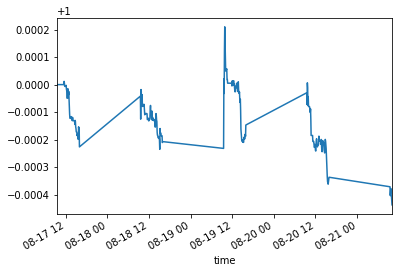

In [25]:
# vizualization of strategy return
%matplotlib inline
(1+strategy_df["ret"]).cumprod().plot()

In [26]:
#calculating individual stock's KPIs
cagr_dict = {}
sharpe_ratios = {}
max_drawdown = {}
hist_dict = {}
for ticker in my_tickers:
    print("calculating KPIs for ",ticker)      
    cagr_dict[ticker] =  cagr(ohlcv[ticker])
    sharpe_ratios[ticker] =  sharpe(ohlcv[ticker],0.025)
    max_drawdown[ticker] =  max_dd(ohlcv[ticker])
    hist_dict[ticker] = ohlcv[ticker]['hist'].max()
KPI_df = pd.DataFrame([cagr_dict,sharpe_ratios,max_drawdown, hist_dict],index=["Return","Sharpe Ratio","Max Drawdown", "Hist"])      
KPI_df.T

calculating KPIs for  AES
calculating KPIs for  AFL
calculating KPIs for  ALK
calculating KPIs for  MO
calculating KPIs for  AMCR
calculating KPIs for  AAL
calculating KPIs for  AIG
calculating KPIs for  AOS
calculating KPIs for  APA
calculating KPIs for  AIV
calculating KPIs for  ADM
calculating KPIs for  T
calculating KPIs for  BKR
calculating KPIs for  BAC
calculating KPIs for  BK
calculating KPIs for  BWA
calculating KPIs for  BSX
calculating KPIs for  COG
calculating KPIs for  CAH
calculating KPIs for  CCL
calculating KPIs for  CARR
calculating KPIs for  CBRE
calculating KPIs for  CNP
calculating KPIs for  CTL
calculating KPIs for  CF
calculating KPIs for  SCHW
calculating KPIs for  CSCO
calculating KPIs for  C
calculating KPIs for  CFG
calculating KPIs for  KO
calculating KPIs for  CMCSA
calculating KPIs for  CMA
calculating KPIs for  CAG
calculating KPIs for  CXO
calculating KPIs for  COP
calculating KPIs for  GLW
calculating KPIs for  CTVA
calculating KPIs for  COTY
calculating

C:\Users\Yiwen L\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


 FCX
calculating KPIs for  GPS
calculating KPIs for  GE
calculating KPIs for  GM
calculating KPIs for  HRB
calculating KPIs for  HAL
calculating KPIs for  HBI
calculating KPIs for  HIG
calculating KPIs for  PEAK
calculating KPIs for  HES
calculating KPIs for  HPE
calculating KPIs for  HFC
calculating KPIs for  HST
calculating KPIs for  HWM
calculating KPIs for  HPQ
calculating KPIs for  HBAN
calculating KPIs for  IR
calculating KPIs for  INTC
calculating KPIs for  IP
calculating KPIs for  IPG
calculating KPIs for  IVZ
calculating KPIs for  IRM
calculating KPIs for  JCI
calculating KPIs for  JNPR
calculating KPIs for  KEY
calculating KPIs for  KIM
calculating KPIs for  KMI
calculating KPIs for  KSS
calculating KPIs for  KHC
calculating KPIs for  KR
calculating KPIs for  LB
calculating KPIs for  LVS
calculating KPIs for  LEG
calculating KPIs for  LNC
calculating KPIs for  LKQ
calculating KPIs for  L
calculating KPIs for  MRO
calculating KPIs for  MPC
calculating KPIs for  MET
calculating

,Return,Sharpe Ratio,Max Drawdown,Hist
AES,-0.002397,-7.072024,0.002397,5.0
AFL,0.000000,-inf,0.000000,0.0
ALK,0.005165,-3.047313,0.002884,2.0
MO,-0.001844,-11.444243,0.002299,2.0
AMCR,-0.002481,-7.985203,0.003809,6.0
AAL,0.020421,-0.158968,0.019103,7.0
AIG,0.000000,-inf,0.000000,0.0
AOS,-0.001541,-10.443839,0.002520,2.0
APA,-0.000482,-7.700205,0.003408,3.0
AIV,0.000000,-inf,0.000000,0.0


In [21]:
KPI_df.T[KPI_df.T.Return > 0.01].sort_values(by = ['Return'], ascending = False)

,Return,Sharpe Ratio,Max Drawdown,Hist
MYL,0.026528,0.071940,0.002651,2.0
AAL,0.020421,-0.158968,0.019103,7.0
GE,0.020315,-0.271439,0.006238,14.0
COG,0.011138,-0.872354,0.005146,4.0


In [28]:
snp_s['symbol'].values.tolist()

['AES',
 'AFL',
 'ALK',
 'MO',
 'AMCR',
 'AAL',
 'AIG',
 'AOS',
 'APA',
 'AIV',
 'ADM',
 'T',
 'BKR',
 'BAC',
 'BK',
 'BWA',
 'BSX',
 'COG',
 'CAH',
 'CCL',
 'CARR',
 'CBRE',
 'CNP',
 'CTL',
 'CF',
 'SCHW',
 'CSCO',
 'C',
 'CFG',
 'KO',
 'CMCSA',
 'CMA',
 'CAG',
 'CXO',
 'COP',
 'GLW',
 'CTVA',
 'COTY',
 'DAL',
 'XRAY',
 'DVN',
 'FANG',
 'DISCA',
 'DISCK',
 'DISH',
 'DOW',
 'DRE',
 'DXC',
 'EOG',
 'EXC',
 'XOM',
 'FAST',
 'FITB',
 'FE',
 'FLIR',
 'FLS',
 'F',
 'FOXA',
 'FOX',
 'BEN',
 'FCX',
 'GPS',
 'GE',
 'GM',
 'HRB',
 'HAL',
 'HBI',
 'HIG',
 'PEAK',
 'HES',
 'HPE',
 'HFC',
 'HST',
 'HWM',
 'HPQ',
 'HBAN',
 'IR',
 'INTC',
 'IP',
 'IPG',
 'IVZ',
 'IRM',
 'JCI',
 'JNPR',
 'KEY',
 'KIM',
 'KMI',
 'KSS',
 'KHC',
 'KR',
 'LB',
 'LVS',
 'LEG',
 'LNC',
 'LKQ',
 'L',
 'MRO',
 'MPC',
 'MET',
 'MGM',
 'MU',
 'TAP',
 'MOS',
 'MYL',
 'NOV',
 'NTAP',
 'NWL',
 'NWSA',
 'NWS',
 'NLSN',
 'NI',
 'NBL',
 'NLOK',
 'NCLH',
 'NRG',
 'NUE',
 'OXY',
 'OKE',
 'PNR',
 'PBCT',
 'PFE',
 'PPL',
 'PFG',
 'PHM',

In [9]:
KPI_df.T[KPI_df.T.Return > 0.01].sort_values(by = ['Return'], ascending = False).iloc[0:20]
my_tickers2 = KPI_df.T[KPI_df.T.Return > 0.01].sort_values(by = ['Return'], ascending = False).iloc[0:20].index.values.tolist()
my_tickers2

['KSS', 'NCLH', 'FTI', 'CCL', 'TPR', 'COG']

In [14]:
my_tickers2[0:10]

['FCX', 'CTL', 'UA', 'BKR', 'RF', 'SYF', 'UNM', 'OKE', 'NLOK', 'IVZ']

In [31]:
ohlcv['BKR']

,open_price,close_price,high_price,low_price,volume,h-l,h-pc,l-pc,tr,atr,roll_max_cp,roll_min_cp,roll_max_vol,ret,hist,cum_return,cum_roll_max,drawdown,drawdown_pct
time,,,,,,,,,,,,,,,,,,,
2020-07-24 09:30:00-04:00,16.7400,17.0600,17.1000,16.7300,35870,0.3700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,1.000000,1.0,0.000000,0.000000
2020-07-24 09:35:00-04:00,17.0600,17.1350,17.1600,17.0200,60217,0.1400,0.1000,0.0400,0.1400,NaN,NaN,NaN,NaN,0.000000,0,1.000000,1.0,0.000000,0.000000
2020-07-24 09:40:00-04:00,17.1100,16.8952,17.1800,16.8800,60018,0.3000,0.0450,0.2550,0.3000,NaN,NaN,NaN,NaN,0.000000,0,1.000000,1.0,0.000000,0.000000
2020-07-24 09:45:00-04:00,16.8900,16.8000,16.9300,16.7700,41857,0.1600,0.0348,0.1252,0.1600,NaN,NaN,NaN,NaN,0.000000,0,1.000000,1.0,0.000000,0.000000
2020-07-24 09:50:00-04:00,16.8100,16.6900,16.8650,16.6750,112569,0.1900,0.0650,0.1250,0.1900,NaN,NaN,NaN,NaN,0.000000,0,1.000000,1.0,0.000000,0.000000
2020-07-24 09:55:00-04:00,16.7200,16.6400,16.7300,16.6400,84483,0.0900,0.0400,0.0500,0.0900,NaN,NaN,NaN,NaN,0.000000,0,1.000000,1.0,0.000000,0.000000
2020-07-24 10:00:00-04:00,16.6350,16.7600,16.7750,16.6000,26660,0.1750,0.1350,0.0400,0.1750,NaN,NaN,NaN,NaN,0.000000,0,1.000000,1.0,0.000000,0.000000
2020-07-24 10:05:00-04:00,16.7682,16.7950,16.8300,16.7350,31498,0.0950,0.0700,0.0250,0.0950,NaN,NaN,NaN,NaN,0.000000,0,1.000000,1.0,0.000000,0.000000
2020-07-24 10:10:00-04:00,16.8000,16.8970,16.9100,16.7850,42256,0.1250,0.1150,0.0100,0.1250,NaN,NaN,NaN,NaN,0.000000,0,1.000000,1.0,0.000000,0.000000
